# Skills lab: Conditional Probabilities
#### Sentiment analysis of tweets with Naive Bayes


The idea of summarizing and visualizing events and emotions of the entire world received a lot of attention in the Machine Learning community. As an example see how the [GDELT project](https://www.gdeltproject.org/) tried to convert world media and news into visualizations of the events and emotions: [LINK](https://firstmonday.org/ojs/index.php/fm/article/view/4366/3654) 

Our goal in this assignment is less extreme: we want to create a system for monitoring emotions of Twitter users and plot the positivity score for small geographic areas on Google maps.

To classify each tweet we are going to use the Naive Bayes classifier, which, despite its “naive” assumptions, has great performance in classifying documents based on their word content.

The main idea of the Document classification with Naive Bayes is as following:

For each new document with words $Word_1 … Word_n$ and each category $c$ compute the probability:

$P(Category = c | Word1 = true, …, Wordn = true) =\alpha*P(Category = c) \prod_{i=1}^n P(Wordi = true | Category = c)$

Then a new document can be classified as belonging to a category $c_{best}$ for which the above probability is the highest:

$c_{best} = argmax(c \in C) P(Category = c | Word_1 = true, …, Word_n = true)$ 

Note, that we don't calculate any real probabilities here. Instead, we are estimating which class is more likely, given the evidence (words). This is another reason why Naïve Bayes is so robust: It is not so much interested in the real probabilities, but only determines which class is more likely. 

## Dataset
Our training dataset was obtained from the Niek Sanders corpus, who has done an awesome job of **manually** labeling more than 5,000 tweets with 4 categories: Positive, Negative, Neutral, and Irrelevant. In general, you could use his script, [install.py](https://github.com/zfz/twitter_corpus.git), to fetch the corresponding Twitter text by tweet id. Because the script is playing nicely with Twitter's servers, it might take quite some time to download the data, so the dataset [full-corpus.csv](https://drive.google.com/file/d/1n3XFcUp8yoLf4BOj0rxEpTw1VCwyK1s-/view?usp=sharing) has been already pre-created for you by your hard-working instructor:). 

We also preprocessed the dataset, leaving only 2 relevant columns: the text of a twit, and the sentiment class. The preprocessed dataset is in file [labeled_corpus.tsv](https://drive.google.com/file/d/1NXvKTuTO6oNjonKkDm2DGdN5fqj-2RE7/view?usp=drive_link), and the tweet text is separated from the class label using tab (‘\t’). That is why the file extension is tsv - which means tab-separated values (similar to csv - comma-separated values). This is our training dataset, used to estimate the probabilities of words given a category. Download the dataset [labeled_corpus.tsv](https://drive.google.com/file/d/1NXvKTuTO6oNjonKkDm2DGdN5fqj-2RE7/view?usp=drive_link), and place it in the same directory where your notebook is.

Let's open the dataset and look at the first five rows:

In [1]:
import csv

with open("labeled_corpus.tsv", encoding="utf-8") as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\t')
    countdown = 5
    
    for row in readCSV:
        line_arr = list(row)

        tweet = line_arr[0]
        sentiment = line_arr[1]        
                 
        print (tweet)
        print (sentiment)
        print()
        
        countdown-=1
        if countdown==0: 
            break

Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is
positive

@Apple will be adding more carrier support to the iPhone 4S (just announced)
positive

Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY
positive

@RIM you made it too easy for me to switch to @Apple iPhone. See ya!
positive

I just realized that the reason I got into twitter was ios5 thanks @apple
positive



We see that some tweets are labeled as 'positive' and others as 'negative'. There are overall four different categories of documents (tweets) in this dataset. Let's store these categories in a set. We can also make use of categories as numbers or as indexes in the array.

In [2]:
categories = {'positive', 'negative', 'neutral', 'irrelevant'}
category_to_num = {"positive": 0, "negative":1, "neutral":2, "irrelevant": 3}
num_to_category = {0: "positive", 1: "negative", 2: "neutral", 3: "irrelevant"}

## Cleaning tweets
The main characteristic of a single tweet is that unlike other documents, the tweet is short (limited by 140 characters) and contains a lot of shortcuts and emoticons. We need to carefully preserve every single word, unlike in normal natural language documents, where we would remove some words (stop words). It is probably wise to remove words starting with @ as they represent user names. It is also desirable to strip the hashtag from the word it is attached to.

To take into account all abbreviations and emoticons, we replace the most obvious of them with the words which may help us with sentiment analysis. The range of frequent emoticons and their replacement is defined in emo_repl dictionary below. 

In [3]:
emo_repl = {
    # positive emoticons
    "&lt;3": " good ",
    ":d": " good ",  # :D in lower case
    ":dd": " good ", # :DD in lower case
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    # negative emoticons:
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":S": " bad ",
    ":-S": " bad ",
}

Here are also the most common abbreviations to be replaced with actual words:

In [4]:
import re #regular expressions module

# Define abbreviations
# as regular expressions together with their expansions
# (\b marks the word boundary):
re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not"
}

In [5]:
# make sure that e.g. :dd is replaced before :d
emo_repl_order = [k for (k_len,k) in
                  reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]

And here is a function that will apply all of the above to a single tweet:

In [6]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    for k in emo_repl_order:
        tweet = tweet.replace(k, emo_repl[k])

    for r, repl in re_repl.items():
        tweet = re.sub(r, repl, tweet)

    return tweet

## Parsing and counting words
To work with a tweet as a document, we first need to obtain separate words from a tweet text. 

Because the same word rarely occurs in a tweet, we are going to account for the presence/absence of a word rather than the count of words per tweet. 

**Stop and think:** words with which prefix should you ignore when parsing a tweet? (#, @?)


<div style="background-color:yellow;">
    <h3>Task 1. Count words in each category</h3>    
</div>

In [7]:
import string
exclude = set(string.punctuation)

def split_tweet(string):
    split = string.split()
    output = []
    for w in split:
        if '#' not in w and '@' not in w:
            str = ""
            for ch in w:
                if (ch not in exclude):
                    str += ch
            output += [str]
    return output

The probabilities of  $P(Word_i = true | Category = c)$ can be easily computed from the dataset as the number of documents in category $c$ which contain this word / total number of documents in this category (conditional probability). $P(Category=c)$ is simply the number of all documents in this category divided by the total number of documents in the dataset.

Based on all the information given above, read the dataset, clean each tweet, remove some prefixed words, and split the tweet into words using the function `split_tweet()` defined above.

Then for each word from an obtained list generate the following counts: 
- Number of tweets in category "positive" that contain this word  
- Number of tweets in category "negative" that contain this word  
- Number of tweets in category "neutral" that contain this word   
- Number of tweets in category "irrelevant" that contain this word   

Also count the total number of tweets in each category and the overall total number of tweets.

Implement this inside the routine called `produce_counts`. Add counts to the corresponding entries of `word_counts_dict` and `total_entries`  

In [8]:
word_counts_dict = {} # "word": [positive, negative, neutral, irrelevant, total counts]
total_entries = [0, 0, 0, 0, 0] #[positive, negative, neutral, irrelevant, total counts]

def produce_counts():
   #TODO Your code goes here
   with open("labeled_corpus.tsv", encoding="utf-8") as csvfile:
      readCSV = csv.reader(csvfile, delimiter='\t')
      for row in readCSV:
         line_arr = list(row)
         tweet_word_list = split_tweet(clean_tweet(line_arr[0]))
         category = line_arr[1]

         if category in category_to_num:
            category = category_to_num[category]
            total_entries[category] += 1
            total_entries[-1] += 1

            for word in tweet_word_list:
               if word not in word_counts_dict:
                  word_counts_dict[word] = [0, 0, 0, 0, 1]
                  word_counts_dict[word][category] += 1
               elif word in word_counts_dict:
                  word_counts_dict[word][-1] += 1
                  word_counts_dict[word][category] += 1


In [9]:
produce_counts()

##### Double-check that your counts are correct
# total positives = 519
print ("total positives =", total_entries[0])

# total negatives = 572
print ("total negatives =", total_entries[1])

# total documents = 5107
print ("total documents =", total_entries[-1])

# #'made': [6, 8, 12, 0, 26]
print(word_counts_dict['made'])
# #'thank': [12, 6, 16, 0, 34]
print(word_counts_dict['thank'])

total positives = 519
total negatives = 572
total documents = 5107
[6, 8, 12, 0, 26]
[12, 6, 16, 0, 34]


## Build Naive Bayes

It is time to build a classifier - that is to precompute: for each category $c$ the $P(Category = c)$, and for each $Word_i$ the value of  $P(Word_i|c)$. 

<div style="background-color:yellow;">
    <h3>Task 2. Compute probabilities</h3>    
</div>

Store the probability for each word in a dictionary `probabilities_dict` where the key is the word itself, and the value is a list of probabilities of this word occuring in 4 different categories. Store prior probabilities of $P(c)$ in `prior_probabilities` list with a separate entry for each category. 

Use counts obtained in the previous section and implement the `probabilities()` function below:

In [10]:
prior_probabilities = [0,0,0,0] #probabilities of 'positive', 'negative', 'neutral', 'irrelevant'
probabilities_dict = {} #key: word, value array [positive, negative, neutral, irrelevant]

def probabilities():
     # calculating the probabilities of a tweet being in any given category
     # positive
     prior_probabilities[0] = total_entries[0] / total_entries[-1]
     # negative
     prior_probabilities[1] = total_entries[1] / total_entries[-1]
     # neutral
     prior_probabilities[2] = total_entries[2] / total_entries[-1]
     # irrelevant
     prior_probabilities[3] = total_entries[3] / total_entries[-1]

     for word in word_counts_dict:
          probabilities_dict[word] = [0, 0, 0, 0]
          # P(word | category) = P(category | word) P(word) / P(category)
          # first is P(cat | word)
          p_pos_word = word_counts_dict[word][0] / word_counts_dict[word][-1]
          p_neg_word = word_counts_dict[word][1] / word_counts_dict[word][-1]
          p_neu_word = word_counts_dict[word][2] / word_counts_dict[word][-1]
          p_irr_word = word_counts_dict[word][3] / word_counts_dict[word][-1]
          p_word = word_counts_dict[word][-1] / total_entries[-1]
          p_positive = prior_probabilities[0]
          p_negative = prior_probabilities[1]
          p_neutral = prior_probabilities[2]
          p_irrelevant = prior_probabilities[3]
          probabilities_dict[word][0] = p_pos_word * p_word / p_positive
          probabilities_dict[word][1] = p_neg_word * p_word / p_negative
          probabilities_dict[word][2] = p_neu_word * p_word / p_neutral
          probabilities_dict[word][3] = p_irr_word * p_word / p_irrelevant

Now run the function and double-check that your probabilities are correct.

In [11]:
probabilities()

print("P('positive')", prior_probabilities[0])     # 0.10162522028588213
print("P('negative')", prior_probabilities[1])     # 0.11200313295476796
print("P('neutral')", prior_probabilities[2])      # 0.4558449187389857
print("P('irrelevant')", prior_probabilities[3])   # 0.3305267280203642 

print(probabilities_dict['made'])   #[0.011560693641618497, 0.013986013986013986, 0.005154639175257732, 0.0]
print(probabilities_dict['thank'])  #[0.023121387283236993, 0.01048951048951049, 0.006872852233676976, 0.0]

P('positive') 0.10162522028588213
P('negative') 0.11200313295476796
P('neutral') 0.4558449187389857
P('irrelevant') 0.3305267280203642
[0.011560693641618497, 0.013986013986013988, 0.005154639175257732, 0.0]
[0.023121387283236993, 0.01048951048951049, 0.006872852233676976, 0.0]


## Classify geo-tagged tweets

The second dataset we are using in this lab is the dataset of geo-tagged tweets containing the latitude and the longitude of an author: [geodata.txt](https://drive.google.com/file/d/1u6fmbjCdsP9AA7z1tkYfLVSMFlDFW-nJ/view?usp=sharing). 

This dataset comes from the paper: “A Latent Variable Model for Geographic Lexical Variation”  
by Jacob Eisenstein, Brendan O'Connor, Noah A. Smith, and Eric P. Xing,  
In Proceedings of the Conference on Empirical Methods in Natural Language Processing, Cambridge, MA, 2010.
 
For this dataset, we want to predict a category label 
of each tweet using probabilities computed in the previous step. 

We cannot use this dataset directly -- we need to redistribute data points into small rectangular areas of the map.
This should be done because Google maps API would not be able to handle all our data points due to the memory and processing power constraints of the browser. Instead, we assign each data point to a small rectangular area of 0.05 x 0.05 degrees in size, and then we compute a single score for each such area to plot the center of the area as a representative of several data points. Note that this step is already completed for you: in the [geo-twits_squares.csv](https://drive.google.com/file/d/1JDEUPGqxGvt9_r8YfQ1yZM_VuQawhHEf/view?usp=sharing) the latitude and longitude represent the upper left corner of a rectangular area to which each original tweet in geo_data.txt belongs. You can download *geo-twits_squares.csv* and place it into the same directory where you store your notebook.

<div style="background-color:yellow;">
    <h3>Task 3. Classify geo-tweets</h3>    
</div>

For each twit in the [geo_twits_squares.tsv](https://drive.google.com/file/d/1JDEUPGqxGvt9_r8YfQ1yZM_VuQawhHEf/view?usp=sharing), compute probabilities of it belonging to one of 4 categories - positive, negative, neutral or irrelevant - and choose the category which is most probable. Perform the same cleaning and parsing procedures as before before computing these classes.

Because the formula for classification contains a lengthy sequence of multiplications, and the multiplied probabilities are all smaller than 1, to prevent a possible numerical underflow,  we should use the log of probability instead, and compare the logs (the logs will be negative, but we still can compare them):

$c_{best} = argmax(c \in C) [log P(Category = c) + \sum_{i=1}^n log P(Word_i = true | Category = c)]$

At the end of this step, you should have a file **locations_classified.tsv**, where for each tweet you keep 3 columns: latitude, longitude, and the most probable class label.

It might take some time to run the classifier, so you might consider using the `tqdm` Python library which will show the progress, but you do not have to. AN example of its usage is shown in the cell below (this cell is not runnable)

In [74]:
from math import * # for log
from tqdm import tqdm

def classify():
    with open("geo_twits_squares.tsv", encoding = "utf-8") as input:
        readTSV = csv.reader(input, delimiter = "\t")
        for i in readTSV:
            tweet_lat = i[0]
            tweet_lon = i[1]
            tweet_word_list = split_tweet(clean_tweet(i[2]))

            # Classifying a tweet: log(P(category)) + sum(log(P(category | word))

            P_pos = log(prior_probabilities[0])
            P_neg = log(prior_probabilities[1])
            P_neu = log(prior_probabilities[2])
            P_irr = log(prior_probabilities[3])

            for word in tweet_word_list:
                if word in probabilities_dict:
                    # print(f"{log(probabilities_dict[word][0])} || {log(probabilities_dict[word][1])} || {log(probabilities_dict[word][2])} || {log(probabilities_dict[word][3])}")
                    if probabilities_dict[word][0] != 0:
                        P_pos += log(probabilities_dict[word][0]) 
                    if probabilities_dict[word][1] != 0:
                        P_neg += log(probabilities_dict[word][1])
                    if probabilities_dict[word][2] != 0:
                        P_neu += log(probabilities_dict[word][2])
                    if probabilities_dict[word][3] != 0:
                        P_irr += log(probabilities_dict[word][3])

            cat_arr = [P_pos, P_neg, P_neu, P_irr]
            classification = cat_arr.index(max(cat_arr))
            with open("geo_twits_squares_output.tsv", "a") as file_write:
                output = f"{tweet_lat}\t{tweet_lon}\t{classification}\n"
                file_write.write(output)

classify()

Now you can run this classification routine, which might take some time to finish. 

If for each tweet you also add the result \[lat, long, class\] to the results array then the first 5 entries in this array should look like:
`[['40.2', '-74.85', 3], ['40.2', '-74.85', 1], ['40.2', '-74.85', 0], ['40.2', '-74.85', 2], ['40.2', '-74.85', 3]]`

In [ ]:
result = []
classify()    
print(result[:5])   

<div style="background-color:green;">
    <h3>Christian: My output is in "geo_twits_squares_output.tsv" in this repository and it is verifiable that classification proceeded properly.</h3>    
</div>

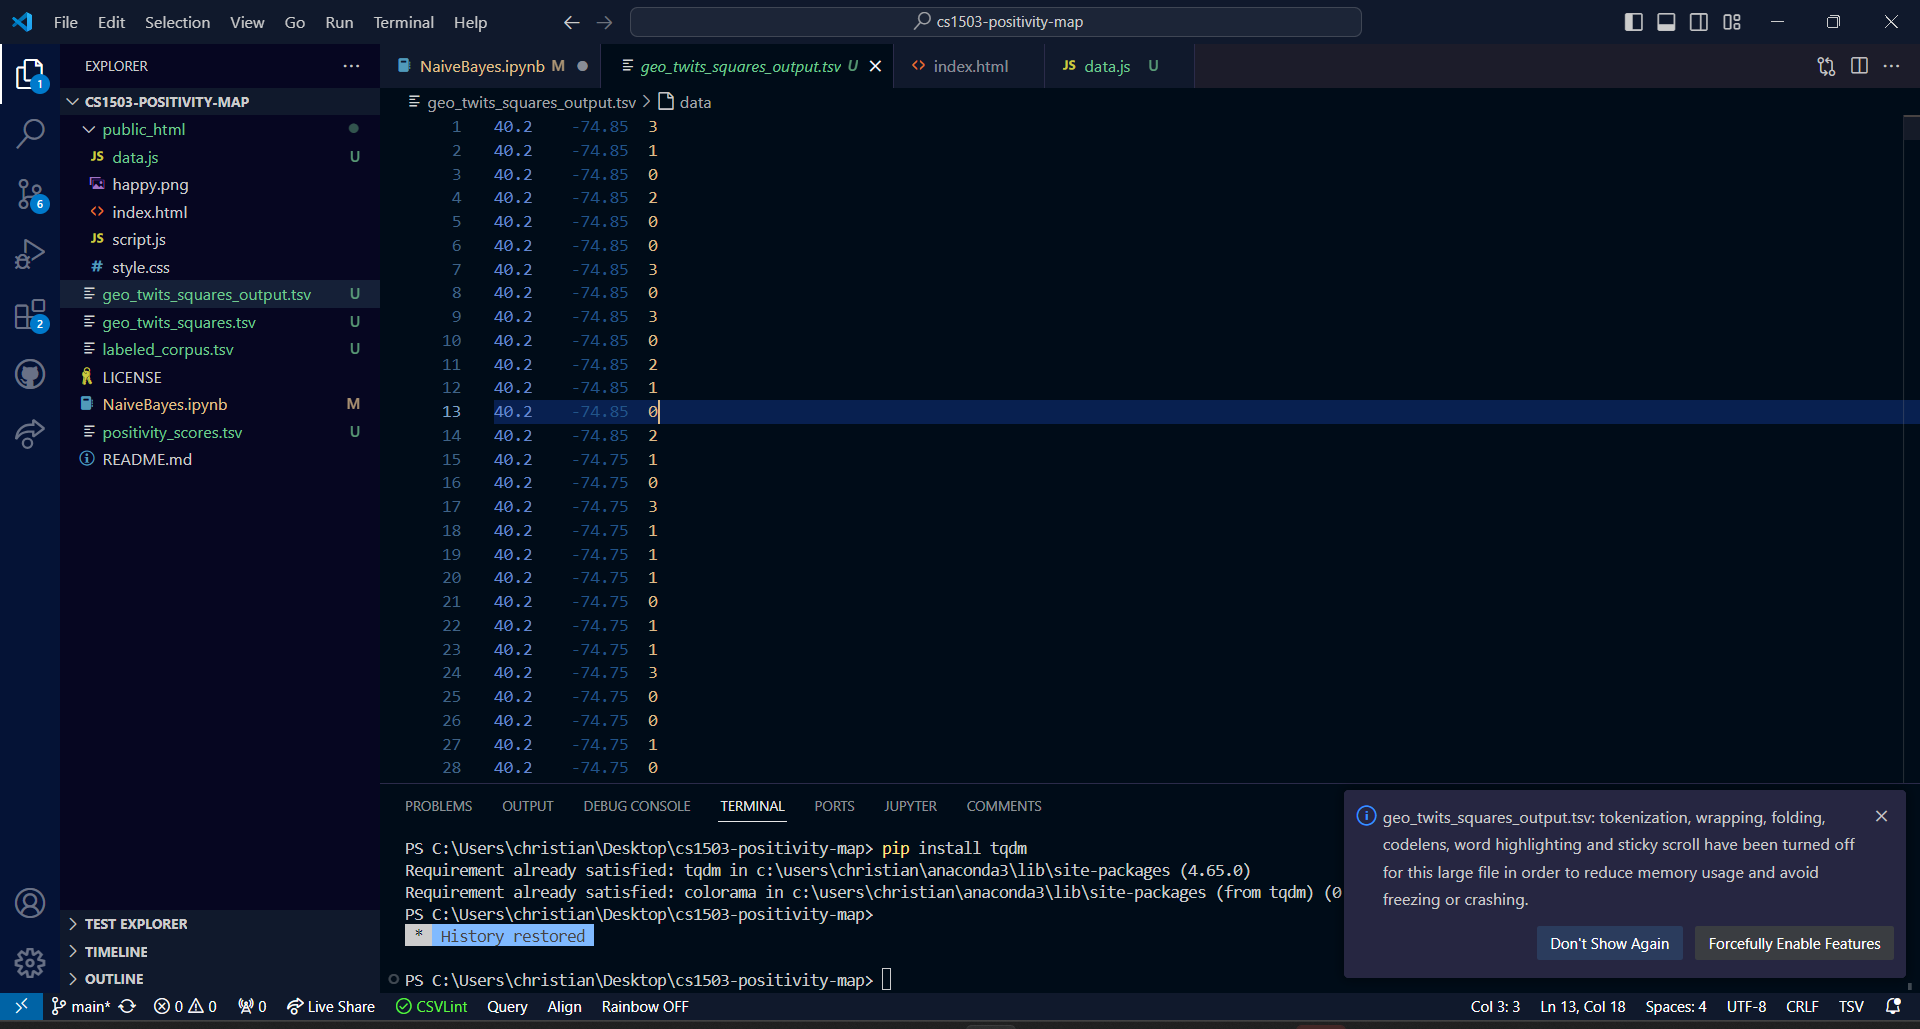

## Positivity score
Here is where some creativity is needed.

Now that we can count the number of total tweets per area, the number of positive twits and the number of negative twits in it, how would you assign a single positivity score to each area?

The goal is to have a single score which reflects both the proportion of positive and the proportion of negative tweets, and we want this score to range from 0 to 1.  We want the score >=0.5 to indicate an overall positive spirit of the area, and the score < 0.5 its negative spirit.

Here is one possible suggestion:

Consider the following example: 
There are a total of 10 tweets in the area.
5 of them are positive, 3 are negative, 2 irrelevant/neutral.
Positivity = total_positive/total - total_negative/total = 5/10 - 2/10 = 3/10 > 0

Let’s say in another square:
2 are positive, 7 are negative, and total is 10.
Positivity = 2/10 - 7/10 = -5/10 < 0.

Because the positivity score defined above varies from -1 to 1, and we want it to vary from 0 to 1, we could just add 1 and divide by 2 - and we get the score in the desired interval.

You can think of a different score, or you can make changes in the visualization code to accommodate the different score interval. 

<div style="background-color:yellow;">
    <h3>Task 4. Compute positivity scores</h3>    
</div>

For each rectangular geographic area compute a single positivity score.

The output from this step is a dataset where for each area we have its left upper corner (latitude, longitude) and the average positivity score. You may store this dataset in file **positivity_score.tsv**. For us to be able to test your work, please  print several scores here.

In [209]:
area_score_nums = {}
# area_score = {}

def positivity_score():
    # methodology: read through geo_twits_squares_output.tsv and store data as a dictionary
    # keys will be the Lat/Lon tuples and the values will be [pos_count, neg_count, total_count]

    with open("geo_twits_squares_output.tsv", "r") as file_read:
        read_class = csv.reader(file_read, delimiter = "\t")
        for i in read_class:
            lat = float(i[0])
            lon = float(i[1])
            curr_tweet_class = int(i[2])
            area = (lat, lon)
            if area not in area_score_nums and curr_tweet_class == 0:
                area_score_nums[area] = [1, 0, 1, 0]
            elif area not in area_score_nums and curr_tweet_class == 1:
                area_score_nums[area] = [0, 1, 1, 0]
            elif area in area_score_nums and curr_tweet_class in [0, 1]:
                area_score_nums[area][curr_tweet_class] += 1
                area_score_nums[area][2] += 1

    for i in area_score_nums:
        area_score_nums[i][3] = (area_score_nums[i][0] / area_score_nums[i][2] - area_score_nums[i][1] / area_score_nums[i][2] + 1)/2

    with open("positivity_scores.tsv", "w") as PenulOut:
        for i in area_score_nums:
            PenulOut.write(f"{i[0]}\t{i[1]}\t{area_score_nums[i][3]}\n")


In [210]:
positivity_score()

In [211]:
print("--- AREA RAW NUMBERS: [POSITIVE_COUNT, NEGATIVE_COUNT, TOTAL_COUNT, PROPORTIONAL SCORE] ---")
for i in area_score_nums:
    print(f"{i}\t\t: {area_score_nums[i]}")

--- AREA RAW NUMBERS: [POSITIVE_COUNT, NEGATIVE_COUNT, TOTAL_COUNT, PROPORTIONAL SCORE] ---
(40.2, -74.85)		: [18, 6, 24, 0.75]
(40.2, -74.75)		: [57, 60, 117, 0.4871794871794872]
(40.2, -74.8)		: [117, 90, 207, 0.5652173913043478]
(40.15, -74.8)		: [6, 9, 15, 0.4]
(40.25, -74.7)		: [0, 3, 3, 0.0]
(40.3, -74.7)		: [6, 3, 9, 0.6666666666666666]
(40.25, -74.8)		: [84, 111, 195, 0.4307692307692308]
(40.25, -74.75)		: [6, 0, 6, 1.0]
(40.1, -74.9)		: [42, 21, 63, 0.6666666666666666]
(40.45, -74.3)		: [60, 57, 117, 0.5128205128205128]
(40.65, -74.0)		: [6399, 5850, 12249, 0.5224099926524615]
(40.8, -73.95)		: [6902, 6289, 13191, 0.5232355393829126]
(40.8, -73.9)		: [2030, 2040, 4070, 0.49877149877149873]
(40.7, -74.0)		: [2734, 2593, 5327, 0.5132344659282898]
(41.9, -87.7)		: [57, 49, 106, 0.5377358490566038]
(41.85, -87.75)		: [103, 100, 203, 0.5073891625615764]
(41.85, -87.7)		: [105, 81, 186, 0.5645161290322581]
(42.05, -88.05)		: [9, 6, 15, 0.6]
(41.75, -87.9)		: [1, 1, 2, 0.5]
(38.15, -

## Visualizing results
Now your goal is to visualize positivity on the map. You can learn how to create your own map visualizations [here](). 

<div style="background-color:yellow;">
    <h3>Task 5. Create visualization input</h3>    
</div>

If you want to use the provided demo template, you would need to create a javascript variable `data` in JSON format and write this object to file `data.js` (located in public_html folder) as following:

`var data =[{"score": 0, "g": -122.197916, "t": 47.528139}, {"score": 0.5, "g": -122.197916, "t": 47.528139}, … ];`

As you see, `data` is an array of Javascript ‘objects’, and each object contains 3 attributes: ‘score’ of the area, ‘g’ for longitude and ‘t’ for latitude. Do not forget to add 0.05/2 to each coordinate to represent the center of the rectangular area rather than its left upper corner.

Dump your resulting object to file `data.js`, place this file into the public_html folder, and explore the visualization by opening index.html in your browser. 

What areas are most positive, which ones are most negative?  Write down your observations in a new cell.

In [215]:
import json

def generate_js_data():
    with open("positivity_scores.tsv", "r") as pos_scores:
        json_dump = []
        read_pos_scores = csv.reader(pos_scores, delimiter = "\t")
        for i in read_pos_scores:
            # i[0] == lat
            # i[1] == lon
            # i[2] == score
            curr_dict = {"score" : float(i[2]),
                         "g" : ((float(i[1]) + 0.05)/2),
                         "t" : ((float(i[0]) + 0.05)/2)
                         }
            json_dump.append(curr_dict)
        json_str = json.dumps(json_dump)
    with open("public_html\data.js", "w") as final_out:
        final_out.write("var data=")
        final_out.write(json_str)
        final_out.write(";")


Run it and test if it worked.

In [216]:
generate_js_data()

## Before you submit
Check that everything still works as expected if you call all your functions one after another:

In [217]:
word_counts_dict = {} # "word": [positive, negative, neutral, irrelevant, total counts]
total_entries = [0, 0, 0, 0, 0] #[positive, negative, neutral, irrelevant, total counts]

produce_counts() #count tweets in training data

prior_probabilities = [0,0,0,0] #probabilities of 'positive', 'negative', 'neutral', 'irrelevant'
probabilities_dict = {} #key: word, value array [positive, negative, neutral, irrelevant]

probabilities() #calculate probabilities
classify() #classify and write locations_classified.tsv
positivity_score() #calculate positivity scores and write positivity_score.tsv
generate_js_data() #write data.js

## Submit your work by committing the forked repository to github. 
*Do not commit any data files: they are too big for github*

### This is the end of the Skill lab 3. 

Copyright &copy; 2024 Marina Barsky.